<a href="https://colab.research.google.com/github/mujibulhaquetanim/DataScience/blob/main/Classify_Spoken_Digits_MC_243102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spoken Digit Classification Using CNN
**Presented By**:
**Name**: Mujibul Haque Tanim \\
**ID**: MC-243102

**Course Teacher**: Mohammad Zainal Abedin. \\
Assistant Proffessor, IIUC. \\
**Course**: Speech Recognition

## Overview
This project implements a deep learning-based speech recognition system to classify spoken digits (0–9) using the **Free Spoken Digit Dataset (FSDD)**, also known as Spoken MNIST. The goal is to preprocess audio recordings, train a Convolutional Neural Network (CNN) to recognize digits from mel spectrograms, and evaluate the model’s performance with metrics and visualizations.

## Objectives
- **Preprocess Audio**: Convert raw audio waveforms into mel spectrograms for feature extraction.
- **Build and Train Model**: Use a CNN to classify spectrograms into one of 10 digit classes.
- **Evaluate Performance**: Generate a confusion matrix, classification report, and accuracy/loss plots to assess model accuracy and identify misclassifications.
- **Demonstrate Inference**: Predict digits from sample audio inputs.

## Dataset
- **Source**: Free Spoken Digit Dataset (FSDD) from `hub://activeloop/spoken_mnist` via Deep Lake.
- **Content**: ~2,000 WAV audio recordings of spoken digits (0–9) in English, sampled at 8 kHz.
- **Structure**: Audio waveforms with corresponding labels (integers 0–9).
- **Preprocessing**: Audio is padded/trimmed to 1 second, converted to mel spectrograms (64 mel bands, 2048 FFT, 512 hop length), and normalized.

## Methodology
1. **Data Loading**: Load the dataset using Deep Lake’s `hub` library.
2. **Preprocessing**: Transform audio into mel spectrograms using `librosa`.
3. **Model Architecture**: A CNN with three Conv2D layers (32, 64, 128 filters), max pooling, and dense layers, using `padding='same'` to handle small spectrogram dimensions.
4. **Training**: Train for 20 epochs with a batch size of 32, using Adam optimizer and sparse categorical crossentropy loss.
5. **Evaluation**:
   - **Confusion Matrix**: Visualize true vs. predicted labels.
   - **Classification Report**: Compute precision, recall, and F1-score per digit.
   - **Accuracy/Loss Plots**: Track training and validation performance.
6. **Inference**: Predict digits from test audio samples.

In [ ]:
!pip install hub

In [ ]:
!pip install "deeplake<4"

**Librosa (0.10.2)**  
   - **Purpose**: Processes audio data and extracts features (mel spectrograms).  
   - **Why Used**: Librosa is a specialized library for audio and music analysis, offering robust tools for spectrogram generation, which is critical for converting raw audio into features suitable for the CNN.  
   - **Usage**: Generates mel spectrograms with `librosa.feature.melspectrogram` and converts power to decibels with `librosa.power_to_db`.

**Deep Lake (deeplake 3.9.18)**  
   - **Purpose**: Loads the Spoken MNIST (FSDD) dataset from `hub://activeloop/spoken_mnist`.  
   - **Why Used**: Deep Lake provides efficient access to large datasets stored in the cloud, streamlining data loading without manual downloading. It’s optimized for machine learning workflows, supporting direct integration with TensorFlow.  
   - **Usage**: Loads audio waveforms and labels via `hub.load`, enabling iteration over the dataset (`sample['audio']`, `sample['labels']`).

In [ ]:
!pip install --upgrade pip
!pip uninstall -y numpy scikit-learn tensorflow librosa matplotlib seaborn deeplake
!pip install numpy==1.26.4 scikit-learn==1.5.2 tensorflow==2.17.0 librosa==0.10.2 matplotlib==3.9.2 seaborn==0.13.2 deeplake==3.9.18

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: librosa 0.10.2
Uninstalling librosa-0.10.2:
  Successfully uninstalled librosa-0.10.2
Found existing installation: matplotlib 3.9.2
Uninstalling matplotlib-3.9.2:
  Successfully uninstalled matplotlib-3.9.2
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
Found existing installation: deeplake 3.9.18
Uninstalling deeplake-3.9.18:
  Successfully uninstalled deeplake-3.9.18
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64

In [ ]:
import tensorflow as tf
import numpy as np
import librosa
import hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models

In [ ]:
# Parameters
SAMPLE_RATE = 8000  # Spoken MNIST typically uses 8 kHz
DURATION = 1.0  # seconds
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 512
NUM_CLASSES = 10  # Digits 0-9
BATCH_SIZE = 32
EPOCHS = 20

def preprocess_audio(audio):
    # Ensure audio is 1D and pad/trim to fixed length
    audio = audio.flatten()
    target_length = int(SAMPLE_RATE * DURATION)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]

    # Create mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=SAMPLE_RATE,
        n_mels=N_MELS,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH
    )
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec


In [ ]:
def load_spoken_mnist():
    # Load dataset from Deep Lake
    ds = hub.load("hub://activeloop/spoken_mnist")

    X, y = [], []
    for sample in ds:
        audio = sample['audio'].numpy()  # Get audio waveform
        label = sample['labels'].numpy()  # Get label (0-9)
        spectrogram = preprocess_audio(audio)
        X.append(spectrogram)
        y.append(label)

    X = np.array(X)[..., np.newaxis]  # Add channel dimension for CNN
    y = np.array(y)

    print(f"Spectrogram shape: {X.shape}")
    return X, y


In [ ]:
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


In [ ]:
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()


In [18]:
def main():
    print("Loading Spoken MNIST dataset...")
    X, y = load_spoken_mnist()

    # Normalize spectrograms
    X = (X - np.mean(X)) / np.std(X)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Build model
    input_shape = (N_MELS, int((SAMPLE_RATE * DURATION) / HOP_LENGTH) + 1, 1)
    print(f"Model input shape: {input_shape}")
    model = build_model(input_shape)
    model.summary()

    # Train model
    print("Training model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE
    )

    # Evaluate model
    print("Evaluating model...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate predictions for confusion matrix and classification report
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(NUM_CLASSES)]))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred_classes)
    print("Confusion matrix saved as 'confusion_matrix.png'")

    # Plot training history
    plot_training_history(history)
    print("Training history plots saved as 'training_history.png'")

    # Save model
    model.save('spoken_mnist_recognition.h5')

    # Example inference
    def predict_digit(audio):
        spectrogram = preprocess_audio(audio)
        spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)
        spectrogram = spectrogram[np.newaxis, ..., np.newaxis]
        prediction = model.predict(spectrogram)
        return np.argmax(prediction[0])

    # Test inference with a sample
    ds = hub.load("hub://activeloop/spoken_mnist")
    sample = ds[0]
    test_audio = sample['audio'].numpy()
    true_label = sample['labels'].numpy()
    predicted_digit = predict_digit(test_audio)
    print(f"Sample prediction: Predicted digit = {predicted_digit}, True label = {true_label}")

if __name__ == "__main__":
    main()

Loading Spoken MNIST dataset...


/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



-

hub://activeloop/spoken_mnist loaded successfully.



Spectrogram shape: (3000, 64, 16, 1)
Model input shape: (64, 16, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 4, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 4, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,666 (4.36 MB)

 Trainable params: 1,142,666 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.2342 - loss: 2.0939 - val_accuracy: 0.7450 - val_loss: 0.8793
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6434 - loss: 0.9970 - val_accuracy: 0.9167 - val_loss: 0.3138
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8113 - loss: 0.5159 - val_accuracy: 0.9650 - val_loss: 0.1803
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8765 - loss: 0.3405 - val_accuracy: 0.9500 - val_loss: 0.1714
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9164 - loss: 0.2396 - val_accuracy: 0.9667 - val_loss: 0.1209
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9307 - loss: 0.1849 - val_accuracy: 0.9833 - val_loss: 0.0643
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9364 - loss: 0.1724 - val_accuracy: 0.9817 - val_loss: 0.0795
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.9570 - loss: 0.1255 - val_ac

Training history plots saved as 'training_history.png'


/

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist



|

hub://activeloop/spoken_mnist loaded successfully.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Sample prediction: Predicted digit = 0, True label = [0]


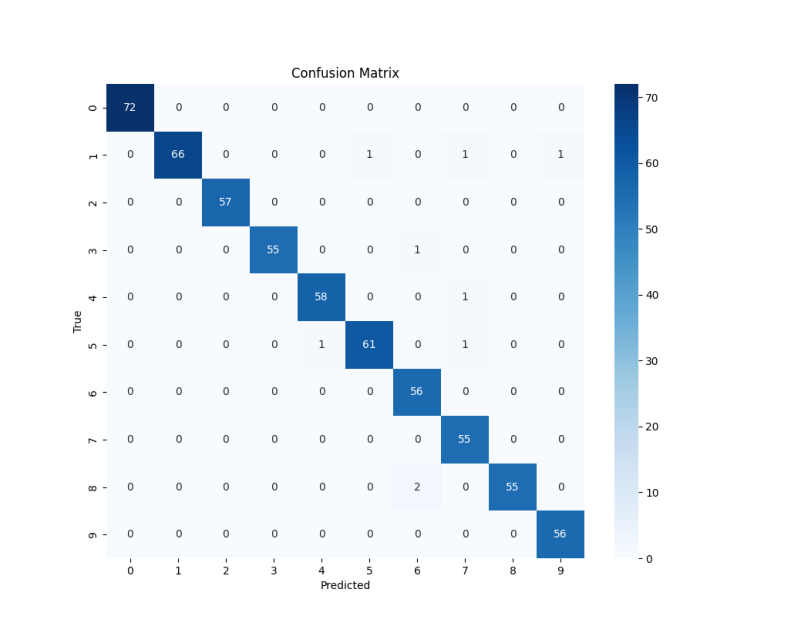

In [19]:
import matplotlib.image as mpimg

img = mpimg.imread('confusion_matrix.png')
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [20]:
pip install deeplake[audio]